## Setting Up:

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle

from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.plots import *
from scripts.config_NOR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.NorwayConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## A. Read GL data:

In [4]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')
# Drop Nan entries in millan_v of Norway dataset
data_wgms = data_wgms.dropna(subset=data_wgms.columns.drop('DATA_MODIFICATION'))

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns


Number of glaciers: 31
Number of winter, summer and annual samples: 5959
Number of annual samples: 3022
Number of winter samples: 2937
Number of summer samples: 0


Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

## B. Progressive Transfer

In [5]:
data_NOR_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_NOR_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'NOR_dataset_monthly_full_with_millanv.csv')
data_monthly_CH_NOR = dataloader_gl.data

display(data_monthly_CH_NOR.head(2))

2025-07-15 21:29:33,905 - INFO - Loaded preprocessed data.
2025-07-15 21:29:33,906 - INFO - Number of monthly rows: 56965
2025-07-15 21:29:33,914 - INFO - Number of annual samples: 36350
2025-07-15 21:29:33,920 - INFO - Number of winter samples: 20615


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-3.957367,0.002545,-120958.0,132238.0,2673505.0,0.518889,-2003158.0,-0.577771,0.414947
1,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-7.107025,0.003408,107086.0,467112.0,414668.0,0.838310,-1135388.0,-1.247729,1.351297


In [6]:
display(data_monthly_CH_NOR['GLACIER'].value_counts())
display(data_monthly_CH_NOR.shape)

display()

GLACIER
Nigardsbreen            14233
Aalfotbreen              8762
Engabreen                3551
Storsteinsfjellbreen     3297
Hansebreen               2611
Graafjellsbrea           2365
Vesledalsbreen           1758
Blaaisen                 1709
Breidablikkbrea          1593
Austre Memurubreen       1580
Rembesdalskaaka          1561
Tunsbergdalsbreen        1517
Austdalsbreen            1326
Blomstoelskardsbreen     1313
Rundvassbreen            1261
Trollbergdalsbreen       1123
Hoegtuvbreen             1015
Svelgjabreen              999
Svartisheibreen           887
Harbardsbreen             771
Bondhusbrea               703
Vestre Memurubreen        556
Cainhavarre               536
Ruklebreen                473
Blabreen                  354
Storglombreen N           265
Graasubreen               230
Hellstugubreen            227
Juvfonne                  162
Moesevassbrea             114
Vetlefjordbreen           113
Name: count, dtype: int64

(56965, 28)

In [7]:
display(data_monthly_CH_NOR[data_monthly_CH_NOR['GLACIER']=='Moesevassbrea'])

,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
4951,2017,6.23614,59.9585,-3.11,903.802191,144.197809,1048,RGI60-08.02920,Moesevassbrea_2017_annual_59.9585_6.23614_N_N_...,496,...,26.157701,1.572174,0.003777,-395486.0,390246.0,5712103.0,0.618483,-2601208.0,-1.033231,-0.056030
4952,2017,6.23614,59.9585,-3.11,903.802191,144.197809,1048,RGI60-08.02920,Moesevassbrea_2017_annual_59.9585_6.23614_N_N_...,496,...,26.157701,-4.637054,0.007868,-67966.0,357024.0,1700736.0,0.727363,-1501804.0,-0.855687,0.249116
4953,2017,6.23614,59.9585,-3.11,903.802191,144.197809,1048,RGI60-08.02920,Moesevassbrea_2017_annual_59.9585_6.23614_N_N_...,496,...,26.157701,-1.432953,0.014975,-24388.0,327584.0,463108.0,0.734155,-638912.0,-0.091323,0.792321
4954,2017,6.23614,59.9585,-3.11,903.802191,144.197809,1048,RGI60-08.02920,Moesevassbrea_2017_annual_59.9585_6.23614_N_N_...,496,...,26.157701,-4.487640,0.007993,-50622.0,253364.0,1180252.0,0.742099,-1347558.0,-0.663486,0.443136
4955,2017,6.23614,59.9585,-3.11,903.802191,144.197809,1048,RGI60-08.02920,Moesevassbrea_2017_annual_59.9585_6.23614_N_N_...,496,...,26.157701,-4.484222,0.006945,-97294.0,426220.0,3672060.0,0.735667,-1789695.0,-1.093056,0.198145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5491,2017,6.30497,60.0165,3.60,1046.390025,568.609975,1615,RGI60-08.02920,Moesevassbrea_2017_winter_60.0165_6.30497_N_N_...,560,...,19.578920,-2.165375,0.015235,-42278.0,-4.0,491500.0,0.838189,-487836.0,-0.022964,0.709802
5492,2017,6.30497,60.0165,3.60,1046.390025,568.609975,1615,RGI60-08.02920,Moesevassbrea_2017_winter_60.0165_6.30497_N_N_...,560,...,19.578920,-5.141937,0.007843,-8078.0,46720.0,1222312.0,0.839465,-1181786.0,-0.567782,0.397726
5493,2017,6.30497,60.0165,3.60,1046.390025,568.609975,1615,RGI60-08.02920,Moesevassbrea_2017_winter_60.0165_6.30497_N_N_...,560,...,19.578920,-5.279144,0.006958,18482.0,230274.0,3825182.0,0.843943,-1396017.0,-1.077919,0.191797
5494,2017,6.30497,60.0165,3.60,1046.390025,568.609975,1615,RGI60-08.02920,Moesevassbrea_2017_winter_60.0165_6.30497_N_N_...,560,...,19.578920,-3.717621,0.009505,-61368.0,42322.0,7050180.0,0.846212,-1267073.0,-0.414123,0.453032


###### 4 glaciers 50% train set

In [6]:
# TRANSFER LEARNING SETUP 50%
# Fine-tuning glaciers (4 Norway glaciers to adapt Swiss model)
train_glaciers = ['Engabreen', 'Nigardsbreen', 'Aalfotbreen', 'Graasubreen']

# Test glaciers (all remaining Norway glaciers)
all_norway_glaciers = list(data_wgms['GLACIER'].unique())
test_glaciers = [g for g in all_norway_glaciers if g not in train_glaciers]

print(f"Fine-tuning glaciers ({len(train_glaciers)}): {train_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Ensure all glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")


## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))


Fine-tuning glaciers (4): ['Engabreen', 'Nigardsbreen', 'Aalfotbreen', 'Graasubreen']
Test glaciers (27): ['Rundvassbreen', 'Hansebreen', 'Austdalsbreen', 'Juvfonne', 'Hellstugubreen', 'Rembesdalskaaka', 'Svelgjabreen', 'Blomstoelskardsbreen', 'Moesevassbrea', 'Storsteinsfjellbreen', 'Svartisheibreen', 'Trollbergdalsbreen', 'Vetlefjordbreen', 'Harbardsbreen', 'Storglombreen N', 'Graafjellsbrea', 'Breidablikkbrea', 'Blaaisen', 'Blabreen', 'Ruklebreen', 'Cainhavarre', 'Tunsbergdalsbreen', 'Vesledalsbreen', 'Austre Memurubreen', 'Vestre Memurubreen', 'Hoegtuvbreen', 'Bondhusbrea']
Train glaciers: (4) ['Engabreen' 'Aalfotbreen' 'Nigardsbreen' 'Graasubreen']
Test glaciers: (27) ['Rundvassbreen' 'Hansebreen' 'Austdalsbreen' 'Juvfonne' 'Hellstugubreen'
 'Rembesdalskaaka' 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Storsteinsfjellbreen' 'Svartisheibreen' 'Trollbergdalsbreen'
 'Vetlefjordbreen' 'Harbardsbreen' 'Storglombreen N' 'Graafjellsbrea'
 'Breidablikkbrea' 'Blaaisen' 'Blabree

###### 5-10% train set

In [6]:
# TRANSFER LEARNING SETUP 5-10%
# Fine-tuning glaciers (4 Norway glaciers to adapt Swiss model)
train_glaciers = [
    'Tunsbergdalsbreen',
    'Austre Memurubreen',
    'Svartisheibreen',
    'Bondhusbrea',
    'Harbardsbreen',
    'Moesevassbrea',
    'Graasubreen'
]

# Test glaciers (all remaining Norway glaciers)
all_norway_glaciers = list(data_wgms['GLACIER'].unique())
test_glaciers = [g for g in all_norway_glaciers if g not in train_glaciers]

print(f"Fine-tuning glaciers ({len(train_glaciers)}): {train_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Ensure all glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")


## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Fine-tuning glaciers (7): ['Tunsbergdalsbreen', 'Austre Memurubreen', 'Svartisheibreen', 'Bondhusbrea', 'Harbardsbreen', 'Moesevassbrea', 'Graasubreen']
Test glaciers (24): ['Rundvassbreen', 'Engabreen', 'Aalfotbreen', 'Hansebreen', 'Nigardsbreen', 'Austdalsbreen', 'Juvfonne', 'Hellstugubreen', 'Rembesdalskaaka', 'Svelgjabreen', 'Blomstoelskardsbreen', 'Storsteinsfjellbreen', 'Trollbergdalsbreen', 'Vetlefjordbreen', 'Storglombreen N', 'Graafjellsbrea', 'Breidablikkbrea', 'Blaaisen', 'Blabreen', 'Ruklebreen', 'Cainhavarre', 'Vesledalsbreen', 'Vestre Memurubreen', 'Hoegtuvbreen']
Train glaciers: (7) ['Moesevassbrea' 'Svartisheibreen' 'Harbardsbreen' 'Graasubreen'
 'Tunsbergdalsbreen' 'Austre Memurubreen' 'Bondhusbrea']
Test glaciers: (24) ['Rundvassbreen' 'Engabreen' 'Aalfotbreen' 'Hansebreen' 'Nigardsbreen'
 'Austdalsbreen' 'Juvfonne' 'Hellstugubreen' 'Rembesdalskaaka'
 'Svelgjabreen' 'Blomstoelskardsbreen' 'Storsteinsfjellbreen'
 'Trollbergdalsbreen' 'Vetlefjordbreen' 'Storglombreen N'

###### Train/val split on random 80/20

In [7]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train data glacier distribution: GLACIER
Nigardsbreen    11380
Aalfotbreen      6934
Engabreen        2922
Graasubreen       203
Name: count, dtype: int64
Val data glacier distribution: GLACIER
Nigardsbreen    2853
Aalfotbreen     1828
Engabreen        629
Graasubreen       27
Name: count, dtype: int64
Train data shape: (21439, 29)
Val data shape: (5337, 29)


###### Train/val split on specific glacier

In [8]:
# Glacier-wise train/val split: validate on Engabreen, train on the other 3
data_train = train_set['df_X']
data_train['y'] = train_set['y']

val_glacier = 'Engabreen'
train_glaciers = [g for g in train_glaciers if g != val_glacier]

df_X_train = data_train[data_train['GLACIER'].isin(train_glaciers)].copy()
y_train = df_X_train['POINT_BALANCE'].values

df_X_val = data_train[data_train['GLACIER'] == val_glacier].copy()
y_val = df_X_val['POINT_BALANCE'].values

print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train data glacier distribution: GLACIER
Nigardsbreen    14233
Aalfotbreen      8762
Graasubreen       230
Name: count, dtype: int64
Val data glacier distribution: GLACIER
Engabreen    3551
Name: count, dtype: int64
Train data shape: (23225, 29)
Val data shape: (3551, 29)


## Neural Network:

In [8]:
def create_period_indicator(df):
    """Create numerical PERIOD_INDICATOR feature"""
    df = df.copy()
    df['PERIOD_INDICATOR'] = df['PERIOD'].map({'annual': 0, 'winter': 1})
    return df

# Apply to all datasets
df_X_train = create_period_indicator(df_X_train)
df_X_val = create_period_indicator(df_X_val)
test_set['df_X'] = create_period_indicator(test_set['df_X'])

print("PERIOD_INDICATOR created:")
print("Annual (0):", (df_X_train['PERIOD_INDICATOR'] == 0).sum())
print("Winter (1):", (df_X_train['PERIOD_INDICATOR'] == 1).sum())
print("Original PERIOD column preserved:", df_X_train['PERIOD'].unique())

PERIOD_INDICATOR created:
Annual (0): 13888
Winter (1): 7551
Original PERIOD column preserved: ['annual' 'winter']


In [8]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate)# + ['PERIOD_INDICATOR']

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

# Because CH has some extra columns, we need to cut those
df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (21439, 28)
Shape of validation dataset: (5337, 28)
Shape of testing dataset: (30189, 28)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


### Initialise network:

In [9]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=1e-4,
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None

def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val

param_init = {'device': 'cpu'}
nInp = len(feature_columns)

checkpoint_cb = Checkpoint(
    monitor='valid_loss_best',
    f_params='best_model.pt',
    f_optimizer=None,     # do not save optimizer state
    f_history=None,       # do not save training history
    f_criterion=None,     # do not save criterion state
    load_best=True,
)


"""
params = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
}

args = {
    'module': FlexibleNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 200,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}

custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)
"""

"\nparams = {\n    'lr': 0.001,\n    'batch_size': 128,\n    'optimizer': torch.optim.Adam,\n    'optimizer__weight_decay': 1e-05,\n    'module__hidden_layers': [128, 128, 64, 32],\n    'module__dropout': 0.2,\n    'module__use_batchnorm': True,\n}\n\nargs = {\n    'module': FlexibleNetwork,\n    'nbFeatures': nInp,\n    'module__input_dim': nInp,\n    'module__dropout': params['module__dropout'],\n    'module__hidden_layers': params['module__hidden_layers'],\n    'train_split': my_train_split,\n    'batch_size': params['batch_size'],\n    'verbose': 1,\n    'iterator_train__shuffle': True,\n    'lr': params['lr'],\n    'max_epochs': 200,\n    'optimizer': params['optimizer'],\n    'optimizer__weight_decay': params['optimizer__weight_decay'],\n    'module__use_batchnorm': params['module__use_batchnorm'],\n    'callbacks': [\n        ('early_stop', early_stop),\n        ('lr_scheduler', lr_scheduler_cb),\n    ]\n}\n\ncustom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_i

### Create datasets:

In [10]:
"""
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)
"""
# Don't create datasets here, create them after loading the Swiss model
features = features_val = None
metadata = metadata_val = None
dataset = dataset_val = None
print("Datasets will be created after loading Swiss model...")

Datasets will be created after loading Swiss model...


In [11]:
import pickle

# Path to your params file
params_path = "/home/mburlet/MBM/MassBalanceMachine/regions/Norway_mb/models/nn_params_2025-07-14_CH_flexible.pkl"

with open(params_path, "rb") as f:
    params = pickle.load(f)

# Print all keys and values
for k, v in params.items():
    print(f"{k}: {v}")

module: <class 'scripts.NN_networks.FlexibleNetwork'>
nbFeatures: 15
module__input_dim: 15
module__dropout: 0.2
module__hidden_layers: [128, 128, 64, 32]
train_split: <function my_train_split at 0x71a40fd0bba0>
batch_size: 128
verbose: 1
iterator_train__shuffle: True
lr: 0.001
max_epochs: 200
optimizer: <class 'torch.optim.adam.Adam'>
optimizer__weight_decay: 1e-05
module__use_batchnorm: True
callbacks: [('early_stop', <skorch.callbacks.training.EarlyStopping object at 0x71a40fd2cf50>), ('lr_scheduler', <skorch.callbacks.lr_scheduler.LRScheduler object at 0x71a40e05d390>)]


### Train custom model:

###### Fine tuning and freezing

In [16]:
TRAIN = True  # Set to True to actually train
if TRAIN:
    # STEP 1: Load the pre-trained Swiss model FIRST
    print("Loading pre-trained Swiss model...")
    model_filename = "nn_model_2025-07-14_CH_flexible.pt"
    
    swiss_args = {
        'module': FlexibleNetwork,
        'nbFeatures': nInp,
        'module__input_dim': nInp,
        'module__dropout': 0.2,
        'module__hidden_layers': [128, 128, 64, 32],
        'module__use_batchnorm': True,
        'warm_start': True, # Important!!! this tells skorch not re-initialize the weights etc.
        'train_split': my_train_split,
        'batch_size': 128,
        'verbose': 1,
        'iterator_train__shuffle': True,
        'lr': 0.001,
        'max_epochs': 200,
        'optimizer': torch.optim.Adam,
        'optimizer__weight_decay': 1e-05,
        'callbacks': [
            ('early_stop', early_stop),
            ('lr_scheduler', lr_scheduler_cb),
            ('checkpoint', checkpoint_cb),
        ]
    }
    
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg, model_filename, **{**swiss_args, **param_init}
    )

    print("✓ Swiss model loaded successfully!")
    
    # STEP 2: Create datasets using the loaded Swiss model
    print("Creating datasets with Swiss model...")
    features, metadata = loaded_model._create_features_metadata(df_X_train_subset)
    features_val, metadata_val = loaded_model._create_features_metadata(df_X_val_subset)
    
    # Create global datasets
    dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features,
                                                    metadata=metadata,
                                                    targets=y_train)
    dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                      SliceDataset(dataset, idx=1))
    
    dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                        features=features_val,
                                                        metadata=metadata_val,
                                                        targets=y_val)
    dataset_val = mbm.data_processing.SliceDatasetBinding(
        SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
    
    print("train:", dataset.X.shape, dataset.y.shape)
    print("validation:", dataset_val.X.shape, dataset_val.y.shape)


    # STEP 2.5: Freeze layers
    for name, param in loaded_model.module_.named_parameters():
        # Freeze layers
        if name not in ['model.0.weight', 'model.0.bias',
                        #'model.1.weight', 'model.1.bias',
                        'model.4.weight', 'model.4.bias',
                        #'model.5.weight', 'model.5.bias',
                        'model.8.weight', 'model.8.bias',
                        #'model.9.weight', 'model.9.bias',
                        'model.12.weight', 'model.12.bias',
                        #'model.13.weight', 'model.13.bias',
                        'model.16.weight', 'model.16.bias'
                        ]:
            param.requires_grad = False
    
    # STEP 3: Update for fine-tuning
    print("Updating model for fine-tuning...")
    loaded_model = loaded_model.set_params(
        lr=0.00001,
        max_epochs=200,
    )
    
    # STEP 4: Fine-tune
    print("Starting fine-tuning...")
    loaded_model.fit(features, y_train)
    
    # STEP 5: Save
    current_date = datetime.now().strftime("%Y-%m-%d")
    finetuned_model_filename = f"nn_model_finetuned_{current_date}"
    loaded_model.save_model(finetuned_model_filename)
    print(f"✓ Fine-tuned model saved as: {finetuned_model_filename}")



Loading pre-trained Swiss model...
✓ Swiss model loaded successfully!
Creating datasets with Swiss model...
train: (484,) (484,)
validation: (121,) (121,)
Updating model for fine-tuning...
Starting fine-tuning...
  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1        1.1335        1.6335     +  0.0000  0.2863
      2        1.1187        1.5362     +  0.0000  0.2677
      3        1.1632        1.4917     +  0.0000  0.2127
      4        1.1911        1.4677     +  0.0000  0.3796
      5        1.2599        1.4468     +  0.0000  0.3123
      6        1.1637        1.4417     +  0.0000  0.3040
      7        1.1185        1.4371     +  0.0000  0.2899
      8        1.1139        1.4324     +  0.0000  0.2893
      9        1.1108        1.4059     +  0.0000  0.2837
     10        1.1166        1.3926     +  0.0000  0.2889
     11        1.1273        1.3872     +  0.0000  0.3001
     12        1.0857        1.37

###### Progressively unfreezing

In [ ]:
TRAIN = True  # Set to True to actually train
if TRAIN:
    # STEP 1: Load the pre-trained Swiss model FIRST
    print("Loading pre-trained Swiss model...")
    model_filename = "nn_model_2025-07-14_CH_flexible.pt"
    
    swiss_args = {
        'module': FlexibleNetwork,
        'nbFeatures': nInp,
        'module__input_dim': nInp,
        'module__dropout': 0.2,
        'module__hidden_layers': [128, 128, 64, 32],
        'module__use_batchnorm': True,
        'warm_start': True, # Important!!! this tells skorch not re-initialize the weights etc.
        'train_split': my_train_split,
        'batch_size': 128,
        'verbose': 1,
        'iterator_train__shuffle': True,
        'lr': 0.001,
        'max_epochs': 200,
        'optimizer': torch.optim.Adam,
        'optimizer__weight_decay': 1e-05,
        'callbacks': [
            ('early_stop', early_stop),
            ('lr_scheduler', lr_scheduler_cb),
            ('checkpoint', checkpoint_cb),
        ]
    }
    
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg, model_filename, **{**swiss_args, **param_init}
    )

    print("✓ Swiss model loaded successfully!")
    
    # STEP 2: Create datasets using the loaded Swiss model
    print("Creating datasets with Swiss model...")
    features, metadata = loaded_model._create_features_metadata(df_X_train_subset)
    features_val, metadata_val = loaded_model._create_features_metadata(df_X_val_subset)
    
    # Create global datasets
    dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features,
                                                    metadata=metadata,
                                                    targets=y_train)
    dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                      SliceDataset(dataset, idx=1))
    
    dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                        features=features_val,
                                                        metadata=metadata_val,
                                                        targets=y_val)
    dataset_val = mbm.data_processing.SliceDatasetBinding(
        SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
    
    print("train:", dataset.X.shape, dataset.y.shape)
    print("validation:", dataset_val.X.shape, dataset_val.y.shape)


    # STEP 2.5: Freeze layers
    
    # Helper to freeze/unfreeze layers
    def set_requires_grad(layer_names, requires_grad=True):
        for name, param in loaded_model.module_.named_parameters():
            if name in layer_names:
                param.requires_grad = requires_grad

    # List of layer groups to progressively unfreeze
    layer_groups = [
        (
        [
            'model.1.weight', 'model.1.bias',
            'model.5.weight', 'model.5.bias',
            'model.9.weight', 'model.9.bias',
            'model.13.weight', 'model.13.bias'
        ],200,  0.1
    ),
        (['model.16.weight', 'model.16.bias'], 200, 0.001),
        (['model.12.weight', 'model.12.bias'], 200, 0.001),
        (['model.8.weight', 'model.8.bias'], 200, 0.001)
    ]

    # Freeze all layers first
    for name, param in loaded_model.module_.named_parameters():
        param.requires_grad = False

    # Progressive unfreezing loop with custom learning rates
    for layers, epochs, lr in layer_groups:
        set_requires_grad(layers, True)
        print(f"Fine-tuning layers: {layers} for {epochs} epochs with lr={lr}...")
        loaded_model = loaded_model.set_params(lr=lr, max_epochs=epochs)
        loaded_model.fit(features, y_train)

        val_score = loaded_model.score(dataset_val.X, dataset_val.y)
        print("Validation score:", val_score)
    
    # STEP 3: Save
    current_date = datetime.now().strftime("%Y-%m-%d")
    finetuned_model_filename = f"nn_model_finetuned_{current_date}"
    loaded_model.save_model(finetuned_model_filename)
    print(f"✓ Fine-tuned model saved as: {finetuned_model_filename}")



Loading pre-trained Swiss model...
✓ Swiss model loaded successfully!
Creating datasets with Swiss model...
train: (2279,) (2279,)
validation: (570,) (570,)
Fine-tuning layers: ['model.16.weight', 'model.16.bias'] for 50 epochs with lr=0.001...
  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1        2.5804        2.0647     +  0.0010  1.0311
      2        2.0145        1.8945     +  0.0010  1.1193
      3        1.7843        1.7026     +  0.0010  1.2149
      4        1.7679        1.7186        0.0010  1.0993
      5        1.7897        1.7217        0.0010  1.0609
      6        1.8600        1.6900     +  0.0010  1.1311
      7        1.9233        1.6768     +  0.0010  1.0182
      8        1.7394        1.7029        0.0010  1.2269
      9        1.8711        1.6208     +  0.0010  1.1847
     10        1.8476        1.7330        0.0010  1.0442
     11        1.8270        1.6254        0.0010  1.1707
 

In [14]:
val_score = loaded_model.score(dataset_val.X, dataset_val.y)
print("Validation score (higher is better):", val_score)

Validation score (higher is better): -0.8127602563156986


In [ ]:
for name, param in loaded_model.module_.named_parameters():
    print(name)
print(loaded_model.module_)

In [ ]:
for name, param in loaded_model.module_.named_parameters():
    print(name, param.data.cpu().numpy().sum())

In [12]:
grouped_ids, scores_NN, ids_NN, y_pred_NN = evaluate_model_and_group_predictions(
    loaded_model, df_X_test_subset, test_set['y'], cfg, mbm)
display(scores_NN)

{'score': -0.8965841187447952,
 'mse': 0.8965841269500342,
 'rmse': 0.9468812633852431,
 'mae': 0.740868883139898,
 'pearson': 0.8823346399672235}

### Load model and make predictions:

In [16]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

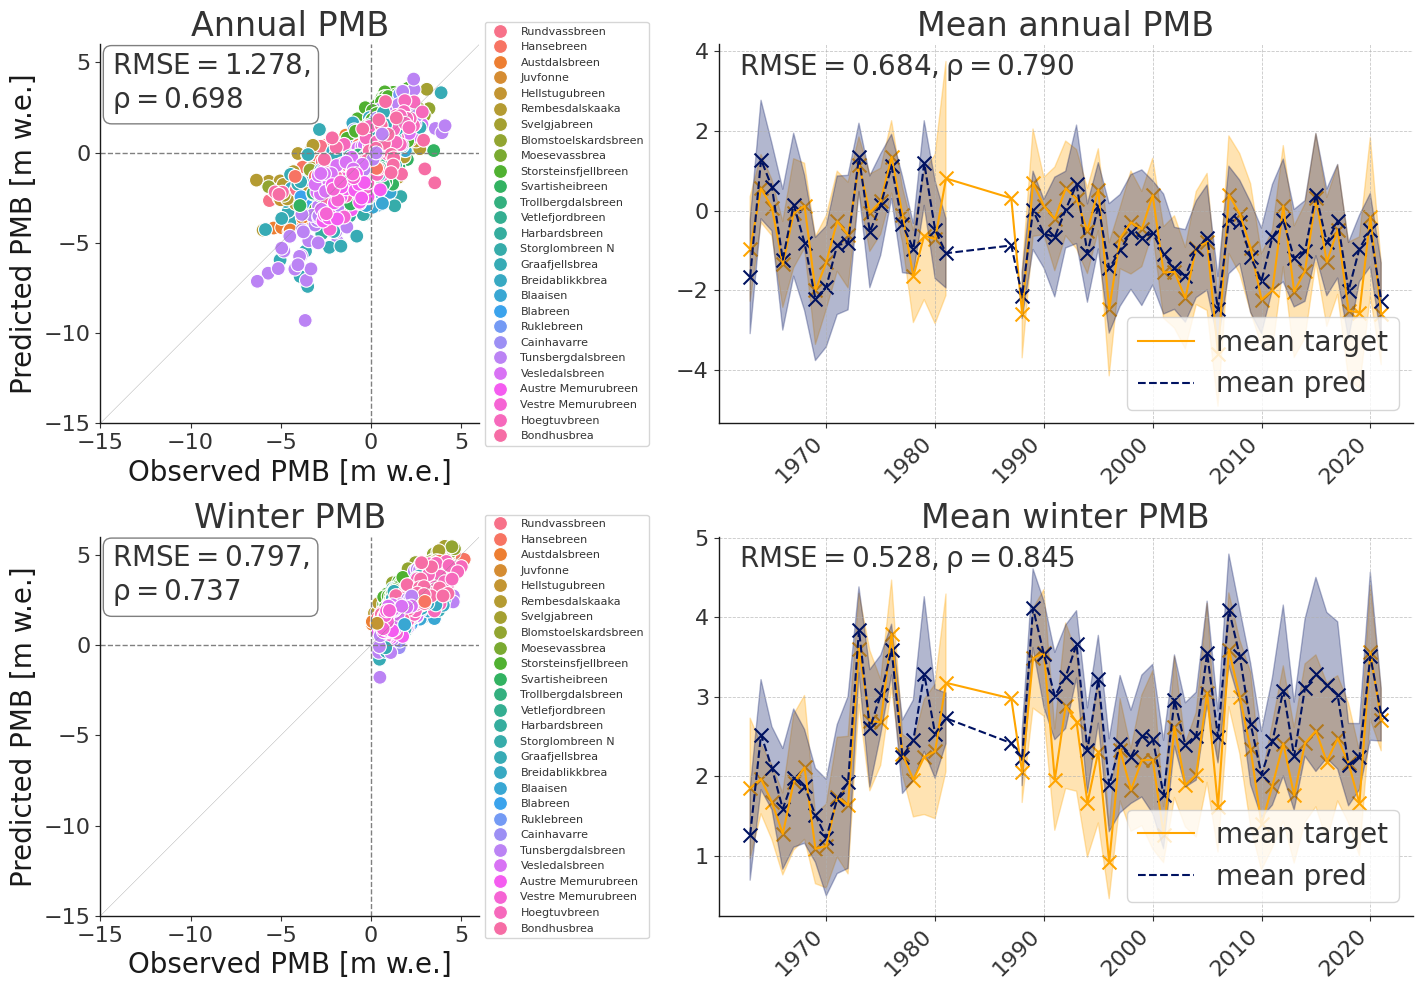

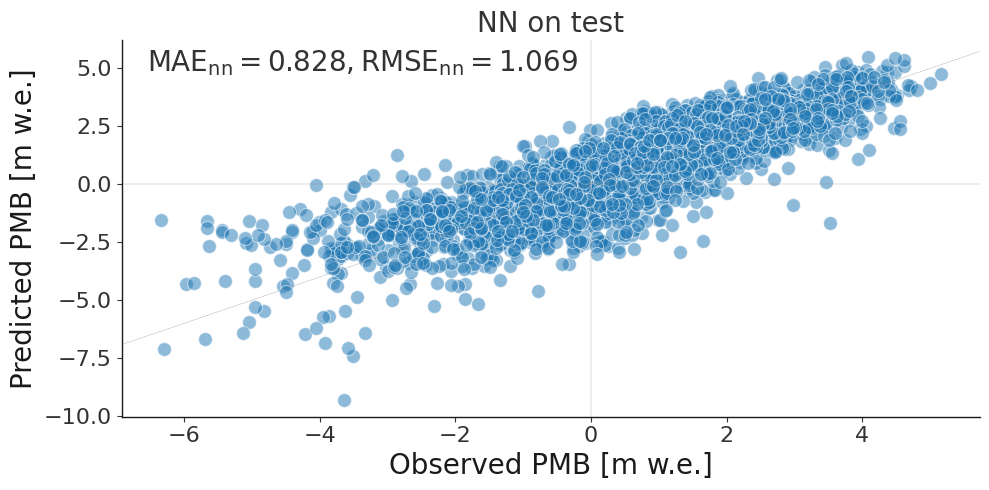

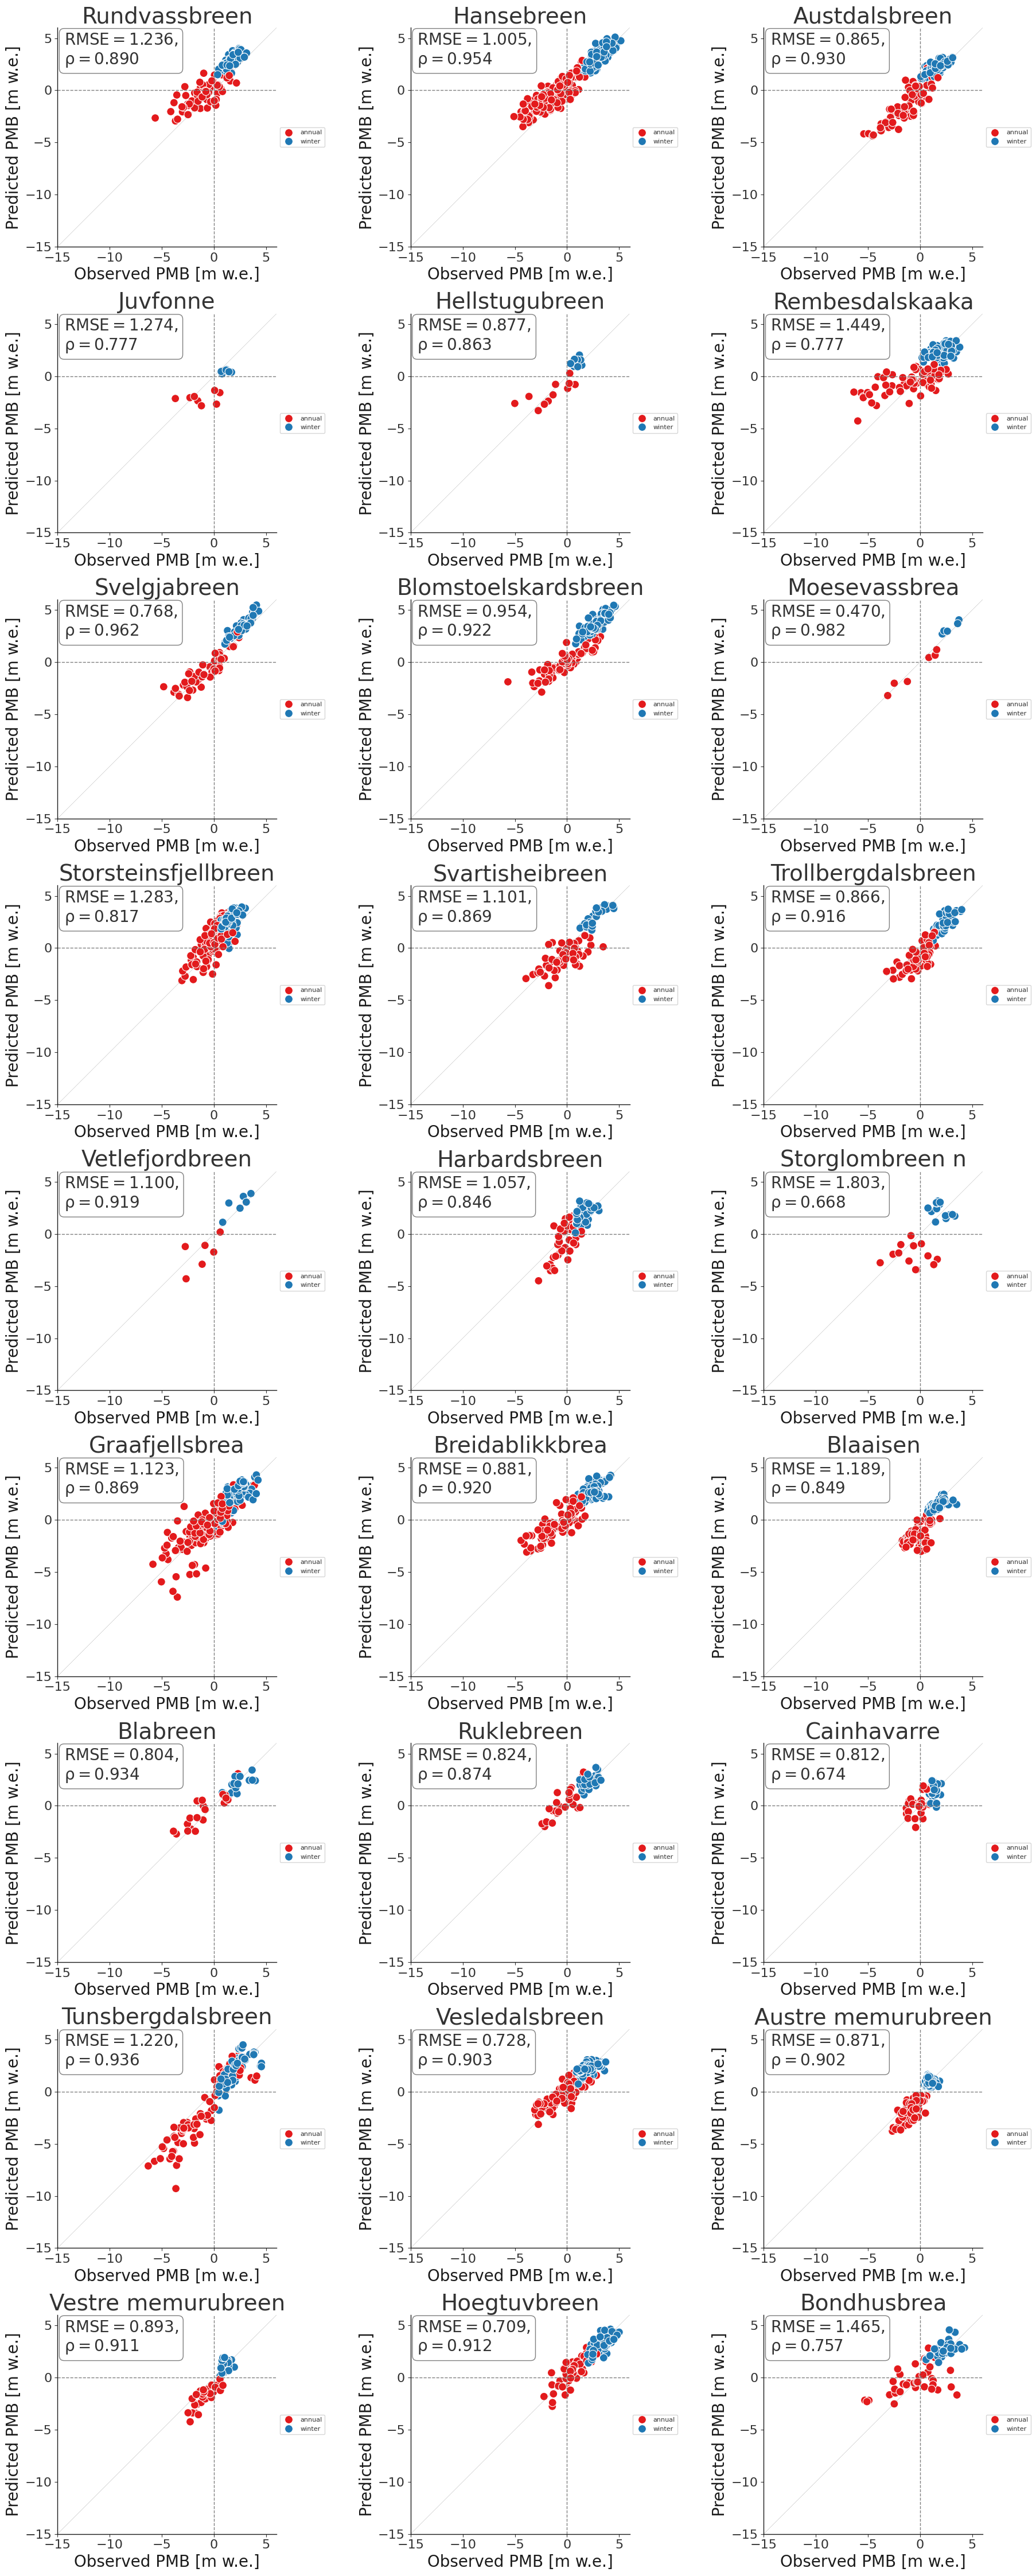

In [17]:
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae, rmse, title='NN on test')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))